#  Olivetti Faces: Clustering & Semi-Supervised Classification
---



## Objective:
The primary goal of this project is to build a machine learning model capable of predicting which person is represented in each picture within the Olivetti faces dataset. Beyond simple classification, this project aims to explore how unsupervised learning techniques, specifically clustering, can be used for dimensionality reduction and feature engineering to enhance model performance.
### Specific Project Goals:
- Data Splitting: Create training, validation, and test sets using stratified sampling to ensure equal representation of each person.
- Clustering: Cluster the face images using $k$-means and visualize the clusters to determine if they capture similar faces.
- Baseline Classification: Train a standard classifier on the original pixel data and evaluate it on the validation set.
- Dimensionality Reduction: Use $k$-means as a dimensionality reduction tool and train a classifier on the reduced dataset.
- Feature Engineering: Experiment by appending the features from the reduced set to the original features.
- Optimization: Search for the optimal number of clusters ($k$) that results in the best classifier performance for both the reduced and combined feature sets.
- Performance Measure:The success of the project will be measured by the classification accuracy achieved on the validation and test sets.


The Olivetti faces dataset
--------------------------

`This dataset contains a set of face images`_ taken between April 1992 and
April 1994 at AT&T Laboratories Cambridge.


As described on the original website:

    There are ten different images of each of 40 distinct subjects. For some
    subjects, the images were taken at different times, varying the lighting,
    facial expressions (open / closed eyes, smiling / not smiling) and facial
    details (glasses / no glasses). All the images were taken against a dark
    homogeneous background with the subjects in an upright, frontal position
    (with tolerance for some side movement).

**Data Set Characteristics:**

======================================
- Classes: 40
- Samples total: 400
- Dimensionality: 4096
- Features: real, between 0 and 1


    The image is quantized to 256 grey levels and stored as unsigned 8-bit
    integers; the loader will convert these to floating point values on the
    interval [0, 1], which are easier to work with for many algorithms.

    The "target" for this database is an integer from 0 to 39 indicating the
    identity of the person pictured; however, with only 10 examples per class.

**credits:  AT&T Laboratories Cambridge.**


# 🛠️  Libraries & Setup
---
Importing necessary tools for data manipulation, visualization, and modeling.

In [2]:
# --- Data Manipulation ---
import pandas as pd
import numpy as np

# --- Visualization ---
import matplotlib.pyplot as plt
import seaborn as sns

# --- Utilities ---
from ipywidgets import fixed, interact
import warnings
warnings.filterwarnings('ignore')

# --- Machine Learning (Sklearn) ---
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline,FeatureUnion
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import mean_squared_error, silhouette_score, accuracy_score
from scipy.stats import randint, uniform,loguniform
from sklearn.multiclass import  OneVsRestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# --- Datasets ---
from sklearn.datasets import fetch_olivetti_faces

# --- Settings ---
pd.set_option('display.max_columns', None)
sns.set_style("whitegrid")




# 📂  Data Loading and Splitting
---
Loading the dataset and performing an initial check on structure.

In [3]:
faces = fetch_olivetti_faces()

downloading Olivetti faces from https://ndownloader.figshare.com/files/5976027 to /root/scikit_learn_data


In [4]:
X = faces.data
y = faces.target
X_train ,  X_test , y_train, y_test = train_test_split(X,y,test_size=0.3,stratify=y, random_state=42)

In [5]:
print(X_train.shape)
print(X_test.shape)

(280, 4096)
(120, 4096)


#  Cluster Analysis
---

Using PCA to Speed up and remove noise.


In [ ]:


pca = PCA(n_components=0.99,random_state=42)
X_train_pca = pca.fit_transform(X_train)


### Defining some useful functions

In [ ]:
def silhouette_plot(X, max_k, min_k=2, step=1):
    """
    Plots the silhouette score for different numbers of clusters.

    This function iterates through a range of cluster numbers (k), fits a KMeans
    model for each k, and plots the silhouette score to help identify the
    optimal number of clusters.

    Parameters
    ----------
    X : array-like of shape (n_samples, n_features)
        The input data samples to cluster (usually X_train).
    max_k : int
        The maximum number of clusters to test (exclusive).
    min_k : int, optional
        The start number of clusters to test. Default is 2 (silhouette requires k >= 2).
    step : int, optional
        The increment step for the range of k values. Default is 1.

    Returns
    -------
    None
        Displays a matplotlib plot directly.
    """


    if min_k < 2:
        print("Warning: min_k adjusted to 2 (silhouette score requires at least 2 clusters).")
        min_k = 2

    ks = range(min_k, max_k, step)
    silhouette_scores = []

    for k in ks:

        model = KMeans(n_clusters=k, random_state=42)
        model.fit(X)


        score = silhouette_score(X, model.labels_)
        silhouette_scores.append(score)

    plt.plot(ks, silhouette_scores, 'bo-')
    plt.title('Silhouette Score per Number of Clusters')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Silhouette Score')
    plt.grid(True)
    plt.show()

In [ ]:
def inertia_plot(X, max_k,min_k = 1,step = 1):
    """
    Plots the inertia for different numbers of clusters to perform the Elbow Method.

    This function iterates through a range of cluster numbers (k), fits a KMeans
    model for each k, and plots the inertia (sum of squared distances to the
    closest cluster center) to help identify the optimal number of clusters.

    Parameters
    ----------
    X : array-like of shape (n_samples, n_features)
        The input data samples to cluster.
    max_k : int
        The maximum number of clusters to test. The function will test k values
        in the range [1, max_k).
    min_k : int, optional
        The start number of clusters to test. The function will test k values
        in the range [min_k, max_k).
    step : int, optional
        The increment step for the range of k values. Default is 1.

    Returns
    -------
    None
        The function displays a matplotlib plot directly and does not return
        an object.
    """
    ks = range(min_k, max_k,step)
    inertias = []

    for k in ks:
        model = KMeans(n_clusters = k,random_state=42)

        model.fit(X)

        inertias.append(model.inertia_)

    plt.plot(ks, inertias, '-o')
    plt.title('Inertia per Number of clusters')
    plt.xlabel('Number of Clusters (K)')
    plt.ylabel('Inertia')
    plt.xticks(ks, rotation=90)
    plt.show()

### Choosing the number of clusters


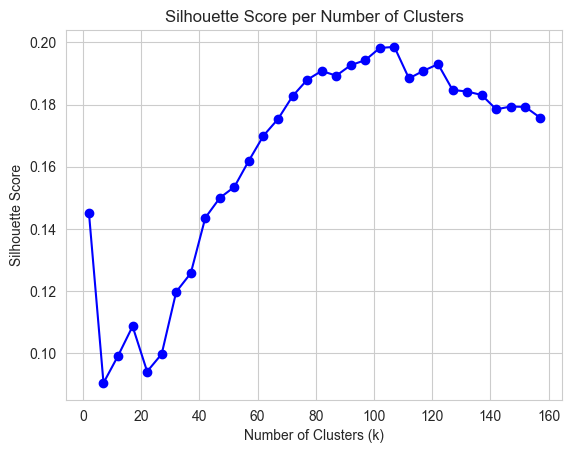

In [ ]:
silhouette_plot(X_train_pca, 160, min_k=2, step=5)

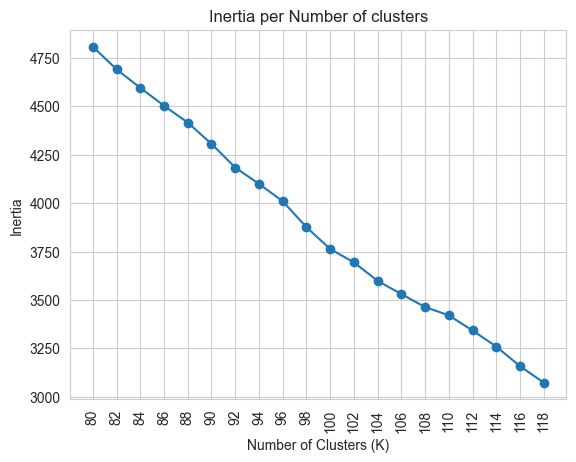

In [ ]:
inertia_plot(X_train_pca,120,80,2)

This is not helpfull at all.

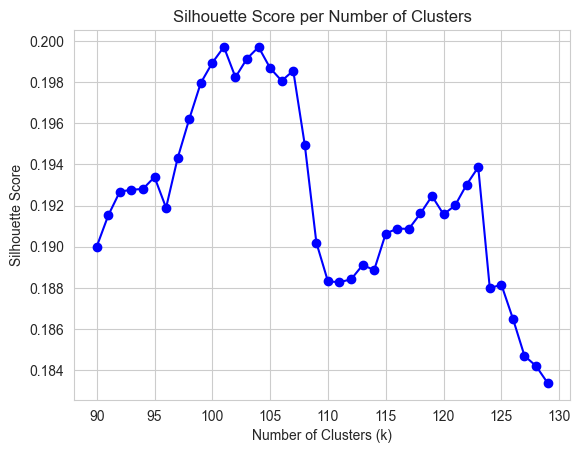

In [ ]:
silhouette_plot(X_train_pca, max_k = 130, min_k=90, step=1)

So , it seems like the optimal number of clusters is 101.

### Visualising Clusters


In [ ]:
def plot_faces(faces, labels, n_cols=5):
    """
    Plots a grid of face images derived from flattened arrays.

    This function reshapes the input face data into 64x64 images and displays
    them in a subplot grid calculated based on the number of images and
    specified columns.

    Parameters
    ----------
    faces : array-like of shape (n_samples, n_features)
        The input data containing face images (typically flattened with 4096 features).
    labels : array-like of shape (n_samples,)
        The target labels corresponding to each face image.
    n_cols : int, optional
        The number of columns in the image grid. Default is 5.

    Returns
    -------
    None
        Displays the matplotlib figure directly.
    """
    faces = faces.reshape(-1, 64, 64)
    n_rows = (len(faces) - 1) // n_cols + 1
    plt.figure(figsize=(n_cols, n_rows * 1.5))
    for index, (face, label) in enumerate(zip(faces, labels)):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(face, cmap="gray")
        plt.axis("off")
        plt.title(label)
    plt.show()

In [ ]:
kclusters = KMeans(n_clusters=101,random_state=42)
kclusters.fit(X_train_pca)


,"n_clusters n_clusters: int, default=8The number of clusters to form as well as the number ofcentroids to generate.For an example of how to choose an optimal value for `n_clusters` refer to:ref:`sphx_glr_auto_examples_cluster_plot_kmeans_silhouette_analysis.py`.",101
,"init init: {'k-means++', 'random'}, callable or array-like of shape (n_clusters, n_features), default='k-means++'Method for initialization:* 'k-means++' : selects initial cluster centroids using sampling based on an empirical probability distribution of the points' contribution to the overall inertia. This technique speeds up convergence. The algorithm implemented is ""greedy k-means++"". It differs from the vanilla k-means++ by making several trials at each sampling step and choosing the best centroid among them.* 'random': choose `n_clusters` observations (rows) at random from data for the initial centroids.* If an array is passed, it should be of shape (n_clusters, n_features) and gives the initial centers.* If a callable is passed, it should take arguments X, n_clusters and a random state and return an initialization.For an example of how to use the different `init` strategies, see:ref:`sphx_glr_auto_examples_cluster_plot_kmeans_digits.py`.For an evaluation of the impact of initialization, see the example:ref:`sphx_glr_auto_examples_cluster_plot_kmeans_stability_low_dim_dense.py`.",'k-means++'
,"n_init n_init: 'auto' or int, default='auto'Number of times the k-means algorithm is run with different centroidseeds. The final results is the best output of `n_init` consecutive runsin terms of inertia. Several runs are recommended for sparsehigh-dimensional problems (see :ref:`kmeans_sparse_high_dim`).When `n_init='auto'`, the number of runs depends on the value of init:10 if using `init='random'` or `init` is a callable;1 if using `init='k-means++'` or `init` is an array-like... versionadded:: 1.2 Added 'auto' option for `n_init`... versionchanged:: 1.4 Default value for `n_init` changed to `'auto'`.",'auto'
,"max_iter max_iter: int, default=300Maximum number of iterations of the k-means algorithm for asingle run.",300
,"tol tol: float, default=1e-4Relative tolerance with regards to Frobenius norm of the differencein the cluster centers of two consecutive iterations to declareconvergence.",0.0001
,"verbose verbose: int, default=0Verbosity mode.",0
,"random_state random_state: int, RandomState instance or None, default=NoneDetermines random number generation for centroid initialization. Usean int to make the randomness deterministic.See :term:`Glossary `.",42
,"copy_x copy_x: bool, default=TrueWhen pre-computing distances it is more numerically accurate to centerthe data first. If copy_x is True (default), then the original data isnot modified. If False, the original data is modified, and put backbefore the function returns, but small numerical differences may beintroduced by subtracting and then adding the data mean. Note that ifthe original data is not C-contiguous, a copy will be made even ifcopy_x is False. If the original data is sparse, but not in CSR format,a copy will be made even if copy_x is False.",True
,"algorithm algorithm: {""lloyd"", ""elkan""}, default=""lloyd""K-means algorithm to use. The classical EM-style algorithm is `""lloyd""`.The `""elkan""` variation can be more efficient on some datasets withwell-defined clusters, by using the triangle inequality. However it'smore memory intensive due to the allocation of an extra array of shape`(n_samples, n_clusters)`... versionchanged:: 0.18 Added Elkan algorithm.. versionchanged:: 1.1 Renamed ""full"" to ""lloyd"", and deprecated ""auto"" and ""full"". Changed ""auto"" to use ""lloyd"" instead of ""elkan"".",'lloyd'


--------------------
Cluster : 15


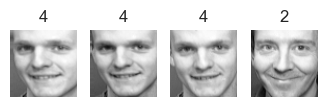

--------------------
--------------------
Cluster : 72


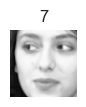

--------------------
--------------------
Cluster : 22


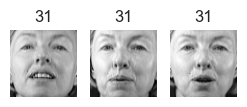

--------------------
--------------------
Cluster : 43


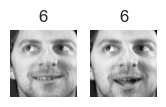

--------------------
--------------------
Cluster : 75


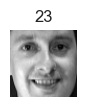

--------------------
--------------------
Cluster : 104


<Figure size 500x0 with 0 Axes>

--------------------
--------------------
Cluster : 7


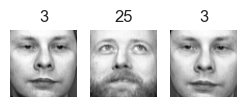

--------------------
--------------------
Cluster : 95


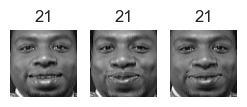

--------------------
--------------------
Cluster : 75


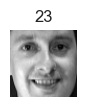

--------------------
--------------------
Cluster : 47


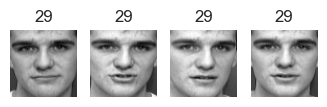

--------------------


In [ ]:
np.random.seed(2)
for index in range(10):
    cluster_id = np.random.choice(130)
    print("-"*20)
    print("Cluster :", cluster_id)
    in_cluster = kclusters.labels_==cluster_id
    faces = X_train[in_cluster]
    labels = y_train[in_cluster]
    plot_faces(faces, labels)
    print("-"*20)

As we can see, there are some clusters that were able to identify the same person with different facial expressions and different angles, others like (clusters 7) that mistook subject 25 with subject 3, and clusters with just one image. let's see if this process is useful to act as a dimensionality reduction tool.

# Building a Classifier
---


## Dimensionality Reduction
---

In [ ]:
preprocess = make_pipeline(PCA(n_components=0.99,random_state=42), KMeans(n_clusters=101,random_state=42))

In [ ]:
print(f"Shape of the raw data :{X_train.shape}")
X_transformed = preprocess.fit_transform(X_train)
print(f"Shape after dimensionality reduction :{X_transformed.shape}")

Shape of the raw data :(280, 4096)
Shape after dimensionality reduction :(280, 101)


We made a reduction of more than 97% of the training set dimension.


## 🧠  Model Selection & Training
---
Training models and searching for optimal hyperparameters.

### Baseline Model
> *Logistic Regrresion on the orginial training set*



In [ ]:
log_reg_baseline = LogisticRegression(max_iter=2000, random_state=42)
baseline_score = cross_val_score(log_reg_baseline, X_train, y_train, cv=3)

print("=" * 30)
print(f"Baseline Model : Logistic Regression")
print(f" Average  Accuracy: {baseline_score.mean()*100:.2f}%")
print(f" Accuracy Standard Deviation: {baseline_score.std()*100:.2f}%")
print("=" * 30)

Baseline Model : Logistic Regression
 Average  Accuracy: 92.50%
 Accuracy Standard Deviation: 1.76%


### Model Comparison


In [ ]:

models = {
    "Logistic Regression" : LogisticRegression(random_state=42, max_iter=3000),
    "KNN": KNeighborsClassifier(),
    "Logistic Regression OVR": OneVsRestClassifier(LogisticRegression(random_state=42, max_iter=3000))
}

In [ ]:
print("-" * 30)
print("WITHOUT DIMENSIONALITY REDUCTION")
print("-" * 30)
scores = {}
for name , model in models.items():
    score = cross_val_score(model,
                    X_train,
                    y_train,
                    cv=3,
                    scoring="accuracy",
                    n_jobs= 4)
    scores[name] = {"mean": score.mean(), "std": score.std()}
    print("=" * 30)
    print(f"Model: {name}")
    print(f" Average  Accuracy: {score.mean()*100:.2f}%")
    print(f" Accuracy Standard Deviation: {score.std()*100:.2f}%")
    print("=" * 30)


------------------------------
WITHOUT DIMENSIONALITY REDUCTION
------------------------------
Model: Logistic Regression
 Average  Accuracy: 92.86%
 Accuracy Standard Deviation: 1.33%
Model: KNN
 Average  Accuracy: 70.72%
 Accuracy Standard Deviation: 1.72%
Model: Logistic Regression OVR
 Average  Accuracy: 92.50%
 Accuracy Standard Deviation: 0.88%


In [ ]:
print("-" * 30)
print("WITH DIMENSIONALITY REDUCTION")
print("-" * 30)
scores_P = {}
for name , model in models.items():
    full_pipeline = make_pipeline(preprocess, model)
    score = cross_val_score(full_pipeline,
                    X_train,
                    y_train,
                    cv=3,
                    scoring="accuracy",
                    n_jobs= 4)
    scores_P[name] = {"mean": score.mean(), "std": score.std()}
    print("=" * 30)
    print(f"Model: {name}")
    print(f" Average  Accuracy: {score.mean()*100:.2f}%")
    print(f" Accuracy Standard Deviation: {score.std()*100:.2f}%")
    print("=" * 30)

------------------------------
WITH DIMENSIONALITY REDUCTION
------------------------------
Model: Logistic Regression
 Average  Accuracy: 87.50%
 Accuracy Standard Deviation: 1.29%
Model: KNN
 Average  Accuracy: 45.00%
 Accuracy Standard Deviation: 0.91%
Model: Logistic Regression OVR
 Average  Accuracy: 88.58%
 Accuracy Standard Deviation: 1.76%


As we expected the Accuracy is lower than using the original dataset.

### Combining features

In [ ]:
union = FeatureUnion([('pixels',"passthrough"),
                            ('preprocess',preprocess)])
ext_pipeline = make_pipeline(union,log_reg_baseline)

print("-" * 30)
print("Combined Features (Pixels + Cluster distances)")
print("-" * 30)

score = cross_val_score(ext_pipeline, X_train, y_train, cv=3, scoring="accuracy", n_jobs=4)

print("=" * 30)
print(f"Baseline Model : Logistic Regression")
print(f" Average  Accuracy: {score.mean()*100:.2f}%")
print(f" Accuracy Standard Deviation: {score.std()*100:.2f}%")
print("=" * 30)

------------------------------
Combined Features (Pixels + Cluster distances)
------------------------------
Baseline Model : Logistic Regression
 Average  Accuracy: 92.50%
 Accuracy Standard Deviation: 0.88%


Combining the features didn't help either.

## Fine-Tunning

> Baseline Model

In [7]:
log_reg = LogisticRegression( max_iter=3000, random_state=42)

param_grid = {
    'C': loguniform(1e-2, 1e2)
}


rnd_search = RandomizedSearchCV(log_reg,
                           param_grid,
                           n_iter=20,
                            cv=3,
                            scoring='accuracy',
                            n_jobs=-1,
                            verbose = 3)
rnd_search.fit(X_train, y_train)

print("=" * 30)
print(f"Best Accuracy : {rnd_search.best_score_*100:.2f}%")
print("Best Params:", rnd_search.best_params_)
print("=" * 30)

Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best Accuracy : 93.22%
Best Params: {'C': np.float64(5.026136608068535)}


> Model with Dimensionality Reduction

In [8]:
full_pipeline = make_pipeline(
    PCA(n_components=0.99, random_state=42),
    KMeans(n_clusters=101, random_state=42),
    LogisticRegression(max_iter=10_000, random_state=42)
)
param_distribs = {

    "kmeans__n_clusters": randint(50, 150),

    "logisticregression__C": randint(1, 100)
}

rnd_search_red = RandomizedSearchCV(full_pipeline,
                           param_distribs,
                           n_iter=20,
                            cv=3,
                            scoring='accuracy',
                            n_jobs=-1,
                            verbose = 3)
rnd_search_red.fit(X_train, y_train)

print("=" * 30)
print(f"Best Accuracy : {rnd_search_red.best_score_*100:.2f}%")
print("Best Params:", rnd_search_red.best_params_)
print("=" * 30)

Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best Accuracy : 89.66%
Best Params: {'kmeans__n_clusters': 125, 'logisticregression__C': 7}


# 📉  Model Evaluation
---
Validating the final model on the test data.

* **Metric:** Accuracy


In [10]:

y_pred = rnd_search.best_estimator_.predict(X_test)
score = accuracy_score(y_pred,y_test)
y_pred_red = rnd_search_red.best_estimator_.predict(X_test)
score_red = accuracy_score(y_pred_red,y_test)
print("-" * 30)
print(f"Baseline Model Test Accuracy: {score*100:.2f}%")
print("-" * 30)
print("-" * 30)
print(f"Model Test Accuracy With Dimensionality Reduction: {score_red*100:.2f}%")
print("-" * 30)


------------------------------
Baseline Model Test Accuracy: 97.50%
------------------------------
------------------------------
Model Test Accuracy With Dimensionality Reduction: 93.33%
------------------------------


# 🔍 7. Conclusion & Insights
---



Unfortunately, our objective of improving classification performance using cluster distances as features was not realized. The test accuracy was 4% lower than the baseline model without these modifications. We also attempted to extend the dataset by combining the cluster features with the original pixels, but this did not improve accuracy either. This suggests that the raw pixel intensity values contain fine-grained details essential for identification that are lost when the data is compressed into cluster centroids. For this specific, well-aligned dataset, a simpler linear approach proved more robust.

